In [1]:
#https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb
from xlib.astock import AStock
import talib as ta
import numpy as np 
import pandas as pd
import mplfinance as mpf

In [9]:
ts_code='002624.sz'
data=AStock.getStockDailyPriceByCode(ts_code,'tushare')
data=data[data['trade_date']>'20210101']
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data=data.set_index('trade_date')   

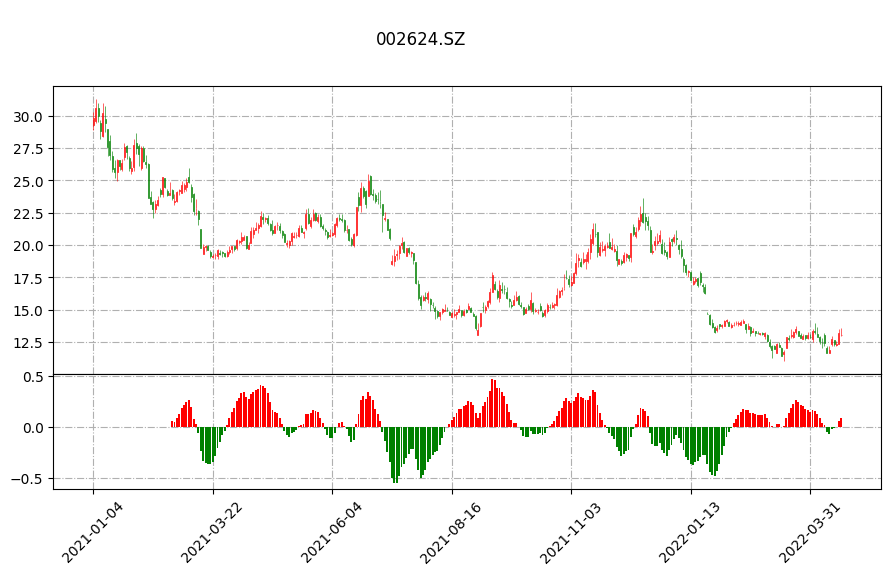

In [10]:
mycolor = mpf.make_marketcolors(up='red',down='green',inherit=True)
mystyle = mpf.make_mpf_style(gridaxis='both',gridstyle='-.',y_on_right=False,marketcolors=mycolor)
data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['close'])
colors = ['r' if v >= 0 else 'g' for v in data["macd_hist"]]
macd_hist_plot = mpf.make_addplot(data["macd_hist"], type='bar', panel=1, color=colors) 
plots = [macd_hist_plot]

mpf.plot(data, 
         type='candle',
         datetime_format='%Y-%m-%d',
         figratio=(20,10), 
         style=mystyle, 
         addplot=plots, 
         title=f"\n002624.SZ", 
         volume=False, 
         volume_panel=2,
         ylabel='', 
         ylabel_lower=''
)


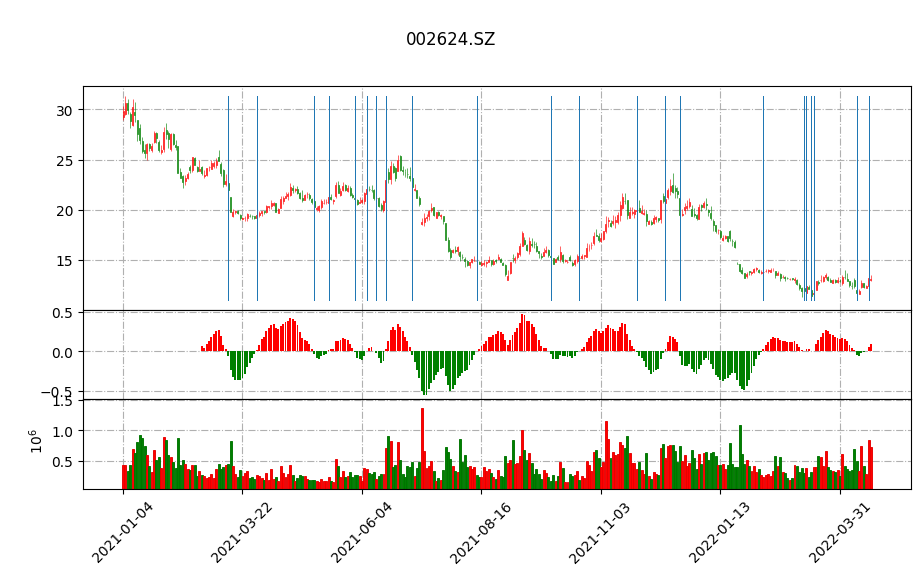

In [11]:
#昨天的macd柱
data['macd_hist_1']= data['macd_hist'].shift(1)
#昨天<=0，今天>0，金叉
data['gold']=data.apply(lambda x: 1 if x['macd_hist_1']<=0 and x['macd_hist']>0   else 0, axis = 1)
#昨天>=0，今天<0，死叉
data['death']=data.apply(lambda x: 1 if x['macd_hist_1']>=0 and x['macd_hist']<0   else 0, axis = 1)

#把金叉或死叉的日期索引记下来
vlines=data[(data.gold==1)|(data.death==1)]
vlines=vlines.index.to_list()


mpf.plot(data, 
         type='candle',
         datetime_format='%Y-%m-%d',
         figratio=(20,10), 
         style=mystyle, 
         addplot=plots, 
         title=f"\n002624.SZ", 
         volume=True, 
         volume_panel=2,
         vlines=dict(vlines=vlines,linewidths=0.5),  #画线
         ylabel='', 
         ylabel_lower=''
        )


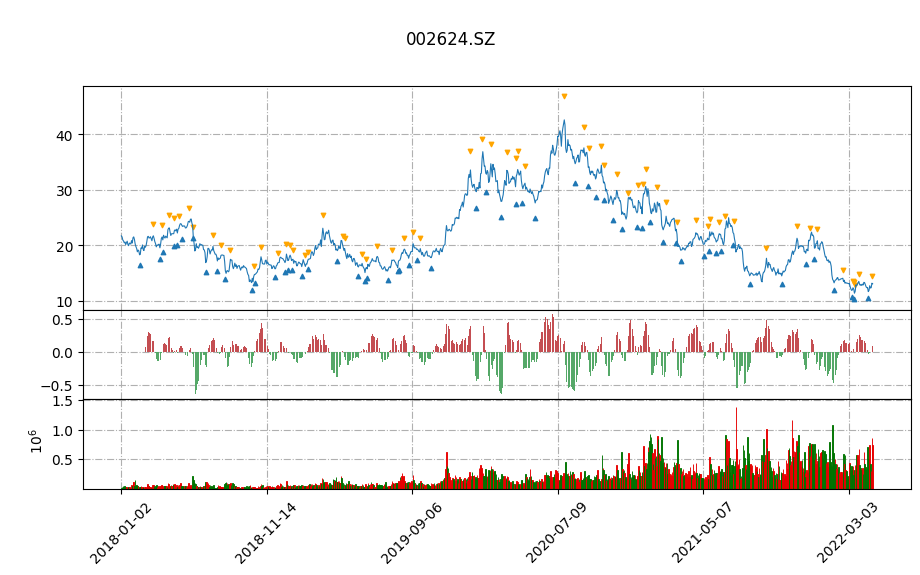

In [42]:
ts_code='002624.sz'
data=AStock.getStockDailyPriceByCode(ts_code,'tushare')
data=data[data['trade_date']>'20180101']
data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data=data.set_index('trade_date')   

data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['close'])
colors = ['r' if v >= 0 else 'g' for v in data["macd_hist"]]
macd_hist_plot = mpf.make_addplot(data["macd_hist"], type='bar', panel=1, color=colors) 

data['macd_hist_1']= data['macd_hist'].shift(1)
data['gold']=data.apply(lambda x: 1 if x['macd_hist_1']<=0 and x['macd_hist']>0   else 0, axis = 1)
data['death']=data.apply(lambda x: 1 if x['macd_hist_1']>=0 and x['macd_hist']<0   else 0, axis = 1)

data['high_signal']=np.nan
data['low_signal']=np.nan


max_value=0
min_value=9999
max_idx=0
min_idx=0


last_max=0
last_min=9999


for index, row in data.iterrows():
    if row['close']>max_value:
        max_value=row['close']
        max_idx=index

    if row['close']<min_value:
        min_value=row['close']
        min_idx=index
    
    if row['gold']==1 or row['death']==1:
        data.at[max_idx,'high_signal']=max_value*1.1
        data.at[min_idx,'low_signal']=min_value*0.9
        max_value=0
        min_value=9999      

        
#清理连续重复的点，在一个循环里也可以搞定，单开一个循环逻辑更清晰
flag="none"
high_value=0
high_index=0
low_value=9999
low_index=0
for index, row in data.iterrows():
    if not (pd.isna(row['high_signal']) and pd.isna(row['low_signal'])):
        if(flag=="none"):
            if not pd.isna(row['high_signal']):
                flag="high"
                high_value=row['close']
                high_index=index
            else:
                flag="low"
                low_value=row['close']
                low_index=index
        elif(flag=="high"):
            #如果上一个标记是high，且这个标记还是high
            if not pd.isna(row['high_signal']):
                #如果现在的收盘价比上一个高点还高，那么清除掉上一个标记
                if(row['close']>high_value):
                    data.at[high_index,'high_signal']=np.nan
                    high_value=row['high_signal']
                    high_index=index
                else:
                    data.at[index,'high_signal']=np.nan
            else:
                flag="low"
                low_value=row['low_signal'] 
                low_index=index
        
        
        elif(flag=="low"):
            #如果上一个标记是low，且这个标记还是low
            if not pd.isna(row['low_signal']):
                #如果现在的收盘价比上一个低点还低，那么清除掉上一个标记
                if(row['close']<low_value):
                    data.at[low_index,'low_signal']=np.nan
                    low_value=row['low_signal']
                    low_index=index
                else:
                    data.at[index,'low_signal']=np.nan
            else:
                flag="high"
                high_value=row['high_signal'] 
                high_index=index        

        else:
            pass
        
high_signal_plot=mpf.make_addplot(data['high_signal'],type='scatter',markersize=10,marker='v',color='orange')
low_signal_plot=mpf.make_addplot(data['low_signal'],type='scatter',markersize=10,marker='^')


plots = [macd_hist_plot,high_signal_plot,low_signal_plot]

mpf.plot(data, 
         type='line',
         datetime_format='%Y-%m-%d',
         figratio=(20,10), 
         style=mystyle, 
         addplot=plots, 
         title=f"\n002624.SZ", 
         volume=True, 
         volume_panel=2,
         #vlines=dict(vlines=vlines,linewidths=0.5),
         ylabel='', 
         ylabel_lower=''
        )

In [37]:
# import pandas as pd
# import tushare as ts
# from xlib.mysql import mysql
# from xlib.astock import AStock

# def fcompute(ts_code,df_cal):
#     df=AStock.getStockDailyPriceByCode(ts_code,db)
#     df=pd.merge(df_cal,df,on=['trade_date'],how='outer', validate="one_to_many")
#     df=df.fillna(method='ffill')
#     df['ts_code']=ts_code
#     df=df[df.trade_date>'20150101']
#     df=df[df.trade_date<'20220410']
#     df=df.reset_index(drop=True)
#     return df    


# db="tushare"
# df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
# pro = ts.pro_api()
# df_code = pro.index_weight(index_code='000300.SH', start_date='20150101', end_date='20220410')
# df_code.drop_duplicates(subset=['con_code'],keep='first',inplace=True)
 
# df_all=[]
# df_code=df_code['con_code'].to_list()

# for ts_code in df_code[:3]:
#     df=fcompute(ts_code,df_cal)
#     df_all.append(df)
#     print(ts_code)

# df_all=pd.concat(df_all)



    
# print(df_all)
# #df_all.to_csv("./xlib/cache/fin.csv")

603195.SH
003816.SZ
300782.SZ
     trade_date    ts_code        open       high         low       close  \
0      20150105  603195.SH         NaN        NaN         NaN         NaN   
1      20150106  603195.SH         NaN        NaN         NaN         NaN   
2      20150107  603195.SH         NaN        NaN         NaN         NaN   
3      20150108  603195.SH         NaN        NaN         NaN         NaN   
4      20150109  603195.SH         NaN        NaN         NaN         NaN   
...         ...        ...         ...        ...         ...         ...   
1762   20220331  300782.SZ  218.847152  219.03721  208.864088  209.984432   
1763   20220401  300782.SZ  207.710000  213.78000  205.500000  212.290000   
1764   20220406  300782.SZ  212.000000  212.00000  202.000000  204.960000   
1765   20220407  300782.SZ  203.330000  207.19000  200.010000  200.490000   
1766   20220408  300782.SZ  200.600000  201.88000  194.280000  198.360000   

       pre_close     change  pct_chg       vo

In [32]:
# import pandas as pd
# from xlib import data
# import akshare as ak

# idx_data = ak.index_zh_a_hist(symbol='000300', period="daily", start_date='20180101', end_date='20220410')    
# idx_data.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', 
#                            '最高':'high', '最低':'low', '成交量':'volume',
#                            '成交额':'amount', '振幅':'swing', '涨跌幅':'chg_pct',
#                            '涨跌额':'chg_amount', '换手率':'turnover',
#                           }, inplace = True)
# idx_data['date'] = pd.to_datetime(idx_data['date'], format='%Y-%m-%d')
# bench=idx_data.set_index('date')

# df=pd.DataFrame()
# df=pd.read_csv('./xlib/cache/fin.csv',index_col=0)
# df=df.reset_index(drop=True)


# print(df)


# # from xlib import backtest
# # preds['score']=preds.apply(lambda x: -9 if x['high']==x['low'] else x['pred'] ,axis=1)
# # preds['rank']=preds.groupby('date')['score'].rank(method='max',ascending=False)
# # preds['signal']=preds.apply(lambda x: 1 if x['rank']<=10 else 0 ,axis=1)



# # returns=backtest.test(preds,Top10Strategy,hold_day=30)

# # preds=preds[preds.signal==1]
# # preds.to_csv("./xlib/cache/preds29.csv")

# # backtest.analysis(returns,bench)

              date     symbol     open      high       low     close  \
0       2015-01-05  603195.SH      NaN       NaN       NaN       NaN   
1       2015-01-06  603195.SH      NaN       NaN       NaN       NaN   
2       2015-01-07  603195.SH      NaN       NaN       NaN       NaN   
3       2015-01-08  603195.SH      NaN       NaN       NaN       NaN   
4       2015-01-09  603195.SH      NaN       NaN       NaN       NaN   
...            ...        ...      ...       ...       ...       ...   
580238  2022-03-31  600340.SH  3.66985  3.949838  3.649851  3.829843   
580239  2022-04-01  600340.SH  4.21000  4.210000  4.210000  4.210000   
580240  2022-04-06  600340.SH  4.63000  4.630000  4.460000  4.630000   
580241  2022-04-07  600340.SH  4.60000  4.600000  4.170000  4.180000   
580242  2022-04-08  600340.SH  4.07000  4.390000  4.010000  4.340000   

        pre_close    change  pct_chg         vol  ...       f12       f13  \
0             NaN       NaN      NaN         NaN  ...     